In [1]:
######## Importing the necessary libraries #########


import pandas as pd
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt



%matplotlib inline   

In [ ]:
import logging
logname = "power_cube.log"
logging.basicConfig(
    filename=logname,
    filemode="a",
    format="%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s",
    datefmt="%H:%M:%S",
    level=logging.DEBUG,
)

In [2]:
##### Fetching the cleaned FM transmitter data for the countries: CANADA, AUSTRALIA ,GERMANY,USA and SOUTH AFRICA ####
#####  EIRP in Watts #####
##### Latitude ranges from 90(N.Pole) to 0 (EQUATOR) to -90(S.Pole) ########
##### Longitude ranges between 0 and 360 degree eastwards ############


#Reading the CSV file
df=pd.read_csv("/home/ghoshsonia/rfi_RRI/Final_Revised.csv")

#Removing the Null/missing values in the CSV file
df.dropna(subset = ["Latitude in degrees"], inplace=True)


,Latitude in degrees,Longitude in degrees,Frequency(MHz),EIRP
0,50.947181,8.532986,87.6,164000.0
1,53.509289,10.093932,87.6,131200.0
2,49.832397,9.592726,87.6,41000.0
3,49.629033,7.820645,87.6,820.0
4,49.681928,7.327415,87.6,328.0
...,...,...,...,...
15610,39.418667,278.557944,88.3,9200.0
15611,38.761750,276.938722,88.3,1700.0
15612,38.722639,276.938722,88.3,1700.0
15613,41.117833,276.456194,88.3,4600.0


In [3]:
###### User defined frequency axis ######################


def get_non_negative_int(prompt):
    while True:
        try:
            value = float(input(prompt))
        except ValueError:
            print("There is an error in the input.")
            continue

        if value<=0:
            print("There is an error in the input.The input cannot be zero or negative")
       # elif value<0:
        #    print("The input must not be negative.")
            continue
        else:
            break
    return value

fstart = get_non_negative_int("Please enter the minimum value of the frequency range: ")
fstop = get_non_negative_int("Please enter the maximum value of the frequency range: ")
fres=get_non_negative_int("Please enter the resolution of the frequency: ")


Please enter the minimum value of the frequency range: 87
Please enter the maximum value of the frequency range: 108
Please enter the resolution of the frequency: 0.5


In [4]:
freq=np.arange(fstart,fstop,fres)

#### Array consisting of frequencies from the dataset
data_freq=df['Frequency(MHz)'].values



diff=np.zeros((len(data_freq),len(freq)),dtype=object)
freq_arr=np.zeros(len(data_freq))


for i in range(len(data_freq)):
    for j in range(len(freq)):
        diff[i][j]=abs(data_freq[i]-freq[j])
        freq_arr[i]=freq[np.argmin(diff[i])]

# freq

In [5]:
df['New Frequency']=freq_arr


,Latitude in degrees,Longitude in degrees,Frequency(MHz),EIRP,New Frequency
0,50.947181,8.532986,87.6,164000.0,87.5
1,53.509289,10.093932,87.6,131200.0,87.5
2,49.832397,9.592726,87.6,41000.0,87.5
3,49.629033,7.820645,87.6,820.0,87.5
4,49.681928,7.327415,87.6,328.0,87.5
...,...,...,...,...,...
15610,39.418667,278.557944,88.3,9200.0,88.5
15611,38.761750,276.938722,88.3,1700.0,88.5
15612,38.722639,276.938722,88.3,1700.0,88.5
15613,41.117833,276.456194,88.3,4600.0,88.5


In [6]:
#Resolution of the map
logging.info("-----------Resolution of the map---------")
nside = 4
logging.info("The number of pixels for the given NSIDE: " + str(hp.nside2npix(nside)))
logging.info("Approximate resolution in degrees for given nside: " + str(np.degrees(hp.nside2resol(nside))))




-----------Resolution of the map---------
The number of pixels for the given NSIDE: 192
Approximate resolution in degrees for given nside: 14.658075357087599
Pixel area: 214.86 square degrees


In [7]:

######-------------------Allocating Pixel number to the Latitude and Longitude of each Tx in the CSV---------#######



# Healpy pixel number when input angles are assumed to be longitude and latitude in degrees
pixel_indices = hp.ang2pix(nside, df['Longitude in degrees'].to_numpy() ,df['Latitude in degrees'].to_numpy(),lonlat=True)
df['Pixel_number']=pixel_indices 
logging.info("The pixel numbers corresponding to the Latitude and Longitude of each Tx is generated")


[12 12 24 ... 36 36 36]


/home/ghoshsonia/.local/lib/python3.8/site-packages/healpy/pixelfunc.py:482: RuntimeWarning: invalid value encountered in _ang2pix_ring
  return pixlib._ang2pix_ring(nside, theta, phi)


,Latitude in degrees,Longitude in degrees,Frequency(MHz),EIRP,New Frequency,Pixel_number
0,50.947181,8.532986,87.6,164000.0,87.5,12
1,53.509289,10.093932,87.6,131200.0,87.5,12
2,49.832397,9.592726,87.6,41000.0,87.5,24
3,49.629033,7.820645,87.6,820.0,87.5,24
4,49.681928,7.327415,87.6,328.0,87.5,24
...,...,...,...,...,...,...
15610,39.418667,278.557944,88.3,9200.0,88.5,36
15611,38.761750,276.938722,88.3,1700.0,88.5,36
15612,38.722639,276.938722,88.3,1700.0,88.5,36
15613,41.117833,276.456194,88.3,4600.0,88.5,36


In [8]:
#######---------------Conversion of the pixel numbers w.r.t the given NSIDE to corresponding angular coordinates--------#######


NPIX = hp.nside2npix(nside) # Storing the number of pixels of the map corresponding to the given NSIDE
arr=np.arange(NPIX) #Create an an array of pixel numbers with respect to the NSIDE

phi,theta = (hp.pix2ang(nside, ipix=arr,lonlat=True)) # Array of the angular coordinates co-latitude(theta) 
                                                        #and longitude(phi) in degrees 
                                                       # With respect to the given NSIDE
logging.info("The number of pixels" + str(NPIX))


In [50]:
#######------------------Altitudes of the satellite orbit--------####


#Creating user defined data points between 400 km to 36000 km in log scale
data_point=int(input("Enter number of data points : "))
altitude= np.logspace(np.log10(400),np.log10(36000),data_point) 

logging.info("Altitudes generated")


Enter number of data points : 2
[  400. 36000.]


In [51]:
#Calculation of Elevation angle

x=np.zeros((NPIX,NPIX))
y=np.zeros((NPIX,NPIX))
elev_ang=np.zeros((len(altitude),NPIX,NPIX))
R_E=6400
for k in range(len(altitude)):
    for i in range(len(theta)):
        for j in range(len(theta)):
        
            x[i,j]=((np.cos(np.radians(theta[i])))*(np.cos(np.radians(theta[j])))*(np.cos(np.radians(phi[j]-phi[i])))+(np.sin(np.radians(theta[i])))*(np.sin(np.radians(theta[j]))))
            y[i,j]=(np.arccos(x[i,j]))
            B=(altitude[k]+R_E)/R_E
            elev_ang[k,i,j]=-(np.degrees(np.arctan((B-np.cos(np.radians(y[i,j])))/np.sin(np.radians(y[i,j]))))-y[i,j])
            
logging.info("Calculation of elevation angle finished")

<ipython-input-51-54968e312daa>:14: RuntimeWarning: divide by zero encountered in true_divide
  elev_ang=-(np.degrees(np.arctan((B-np.cos(np.radians(y)))/np.sin(np.radians(y))))-y)


In [52]:

# Function for Radiation pattern of the satellite antenna beam #
beam_pattern=np.zeros((len(altitude),NPIX,NPIX))
beam = lambda theta, phi: (np.cos(np.radians(theta)))**2  


In [53]:
# Assuming the satellite antenna beam to be symmetric across azimuth #
# Calculation of the beam pattern #

az=0
beam_pattern = beam(elev_ang,az)


In [54]:
###########----------------- Calculation of Field of view of the satellite---------#######
###########-----------------Considering Nadir-pointing Field of View Geometry-------######
##########-----------------Considering the FOV of the satellite to be tangent to the surface of the Earth------######


FOV=np.zeros(len(altitude))
for i in range(0,len(altitude)):
# Consider a case of full coverage under elevation of 0 º
    Rad= 6371 # Mean radius of Earth in km
    FOV[i]= 2*np.arcsin(Rad/(Rad+ altitude[i]))  # Field of view for maximal coverage in radians when elevation is 0 º 
    
    logging.info("The Field of view of the satellite at a height of",altitude[i],"km is",FOV[i], "radians")
    

 The Field of view of the satellite at a height of 400.0000000000001 km is 2.4507006996152447 radians
 The Field of view of the satellite at a height of 35999.99999999996 km is 0.30186940950576446 radians


In [55]:
###########----------------- Calculation of the radius of the FOV of the satellite---------#######



# The surface of the coverage area of the Earth depends on the central angle
Central_angle=np.zeros(len(altitude))
for i in range(0,len(altitude)):
    Central_angle[i]=np.arccos(Rad/(Rad+altitude[i])) # Central angle in radians
    
    Dia_of_FOV=2*Central_angle*Rad  # Diameter of the FOV (disc on the Earth's surface)in km
    Rad_of_FOV= Dia_of_FOV/2 # Radius of the FOV in km
    Rad_of_FOV=Rad_of_FOV/Rad  # Radius of the FOV in Radians
    logging.info(" The Radius of the Field of View for a height of",altitude[i],"km in radians is",Rad_of_FOV[i])


 The Radius of the Field of View for a height of 400.0000000000001 km in radians is 0.3454459769872743
 The Radius of the Field of View for a height of 35999.99999999996 km in radians is 1.4198616220420144


2

In [56]:
###############-----Storing indices of the pixel number that are inside the circle/disc(FOV) wrt the altitude-----------######


vec1 = hp.ang2vec(phi,theta,lonlat=True) #Using ang2vec convert angles that is co-latitude and longitude in radians
                                        #to 3D position vector
    
disc=np.zeros((len(arr),len(Rad_of_FOV)),dtype=object)#Array of indices of the pixel number that are inside the 
                                                      #circle/disc specified by vec and radius
def pixel_disc(a,b):
    for i in range(len(a)):
        for j in range(len(b)):
            disc[j][i]=hp.query_disc(nside, vec1[j], radius=a[i])
pixel_disc(Rad_of_FOV,arr)

In [57]:
######-----Storing indices of the pixel number that are common between the FOV disc and the satellite pixel no------####


Comm_pix=np.zeros((len(disc[:,i]),len(Rad_of_FOV)),dtype=object)

for i in range(len(Rad_of_FOV)):
    for k in range(len(disc[:,i])):
     

         Comm_pix[k][i]=np.intersect1d(pixel_indices,disc[k][i])#Array of indices of the pixel number that are
                                                           #common between the FOV disc and the satellite pixel no
         

In [58]:
######-----Storing indices of the pixel number that are common between the FOV disc and the satellite pixel no ------#
######-----And the same pixel number of the transmitters-----##



######--- Initializing the array to store the pixel number that are common between the FOV disc ---####
######                        and the satellite pixel no    ######
Comm_TX=np.zeros((len(Comm_pix),len(Rad_of_FOV)),dtype=object)
found_common=np.zeros(( len(Comm_pix),len(Rad_of_FOV)),dtype=object)

for j in range(len(Rad_of_FOV)):
    for i in range(len(Comm_pix)):
        
        Comm_TX[i][j]=set(Comm_pix[i][j])
        found_common[i][j] = [l for l in pixel_indices if l in Comm_TX[i][j]]#Array of indices of the pixel number that 
                                            #are common between the FOV disc and the satellite pixel no with
                                                    # Tx having same pixel number
                                                                       
logging.info("Common Pixel matrix generated")         

In [59]:
#######-------Store the values of the received power in Watt,dBm and Kelvin wrt altitude----#####
######------- Calculation of the received power using Friis Transmission Equation--------#######
######-------Considering isotropic transmitter and receiver with gain =1 -------------#########





#res=fres*1e6 #Bandwidth
res=200*1e3
Rx_Power= np.zeros((len(df),len(altitude)))
Rx_Power_in_Kelvin=np.zeros((len(df),len(altitude)))
for i in range(0,len(altitude)):
    for j in range(0,len(df)):
        wavelength= (3*1e8)/(df.iloc[j]['Frequency(MHz)']*1e6)
        Rx_Power[j][i]= ((df.iloc[j]['EIRP'])*(wavelength)**2)/(4*np.pi*altitude[i]*1e3)**2 #the Friis Transmission Equation
        
        Rx_Power_in_Kelvin[j][i]=Rx_Power[j][i]/(1.38*1e-23*res)#in Kelvin
        

       

In [60]:
##### ---Create dataframe to store the values of the received power in Kelvin w.r.t the altitude----#####

##### The first three columns of the dataframe indicate the altitude [0=400 km, 1= 3794 km , 2= 36000 km ] #####
##### The column will vary with the user input for the number of altitudes ######

df_data=pd.DataFrame(Rx_Power_in_Kelvin)
df_data['Pixel_number']=pixel_indices
df_data['New Frequency']=freq_arr



,0,1,Pixel_number,New Frequency
0,2.758223e+10,3.405213e+06,12,87.5
1,2.206578e+10,2.724171e+06,12,87.5
2,6.895557e+09,8.513033e+05,24,87.5
3,1.379111e+08,1.702607e+04,24,87.5
4,5.516446e+07,6.810427e+03,24,87.5
...,...,...,...,...
14698,1.522861e+09,1.880075e+05,36,88.5
14699,2.813981e+08,3.474051e+04,36,88.5
14700,2.813981e+08,3.474051e+04,36,88.5
14701,7.614303e+08,9.400374e+04,36,88.5


In [62]:
#########  Create dataframes for the FOV for each pixel position of the satellite at different altitudes #######



######--- Initializing the array to store the dataframes for the FOV for each pixel position of the satellite #####
######            at different altitudes   ######


df_1=np.zeros((len(found_common),len(Rad_of_FOV)),dtype=object)

for j in range(len(Rad_of_FOV)):
    for i in range(len(found_common)):
        df_1[i][j]= df_data.loc[df_data['Pixel_number'].isin(found_common[i][j])]
        df_1[i][j][j]=df_1[i][j][j]*beam_pattern[i,found_common[i,j]]
       # df_1[i][j]['Rx_Power in Watt at 3795 km']=df_1[i][j]['Rx_Power in Kelvin at 3795 km']*beam_pattern[i,found_common[i,j]]
       # df_1[i][j]['Rx_Power in Watt at 36000 km']=df_1[i][j]['Rx_Power in Kelvin at 36000 km']*beam_pattern[i,found_common[i,j]]
        df_1[i][j]= df_1[i][j].groupby(['New Frequency']).sum()  # df9['Pixel_number']= Column consisting of 
        df_1[i][j]= df_1[i][j].reset_index() 
logging.info("Dataframes for the FOV for each pixel position at different altitudes generated ")    

<ipython-input-62-c7596bd1b02d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1[i][j][j]=df_1[i][j][j]*beam_pattern[i,found_common[i,j]]


In [442]:
## Initializing the 3D array to store the received power for each pixel, each frequency and at different altitudes ###

power_output=np.zeros((len(Rad_of_FOV),NPIX,len(freq)),dtype=object)


In [443]:
## Create the 3D array to store the received power for each pixel, each frequency and at different altitudes ##
## k: loops along the length of the number of altitude
## m: loops along the length of the number of pixels based on the given NSIDE
## l: loops along the length of the number of frequencies in the frequency axis defined by user



for k in range(len(Rad_of_FOV)):
    for m in range(NPIX):    
        for l in range(len(freq)):
            if (df_1[m][k][k][df_1[m][k]['New Frequency'] == freq[l]].values).size==0:# checking for empty dataframes
                power_output[k][m][l]=0
            else: 
                power_output[k][m][l]=float(df_1[m][k][k][df_1[m][k]['New Frequency'] == freq[l]].values)
           

logging.info("3D Power cube generated")      

0.0 180.0 -180.0 180.0


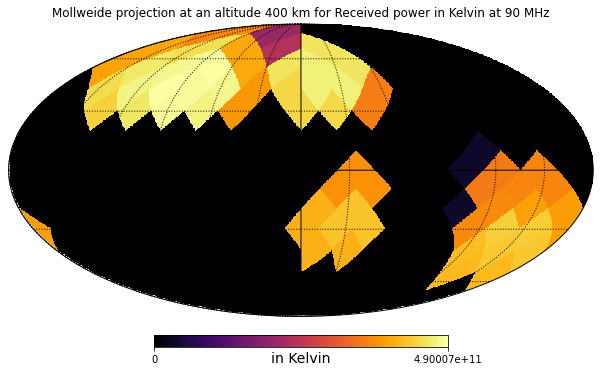

In [444]:
test_plot00 = np.zeros(hp.nside2npix(nside))
test_plot00[0:np.size(power_output[0,:,6])] = power_output[0,:,6]
hp.mollview(test_plot00,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 400 km for Received power in Kelvin at 90 MHz",flip='geo',norm='hist')#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()
plt.savefig('Map_400_at_90.png')
plt.close()
logging.info("Plot for alt 400 at 90 generated ")

In [ ]:
test_plot01 = np.zeros(hp.nside2npix(nside))
test_plot01[0:np.size(power_output[len(altitude)-1,:,6])] = power_output[len(altitude)-1,:,6]
hp.mollview(test_plot01,cmap='inferno',unit="in Kelvin",title="Mollweide projection at highest altitude in km for Received power in Kelvin at 90 MHz",flip='geo',norm='hist')#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()
plt.savefig('Map_highest_alt_at_90.png')
plt.close()
logging.info("Plot for highest alt at 90 generated ")

In [ ]:
logging.info("Finished Run")
logging.shutdown()